### SI Figure notebook refuting PM1 rare cell cluster via spatial analysis

In [118]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.lines import Line2D
import numpy as np
import anndata
import scanpy
import string
import seaborn as sns
import h5py
import scvi
%matplotlib inline

mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,8])
    plt.rc('svg', fonttype='none')

# To do: 

/home/jonathan.liu/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


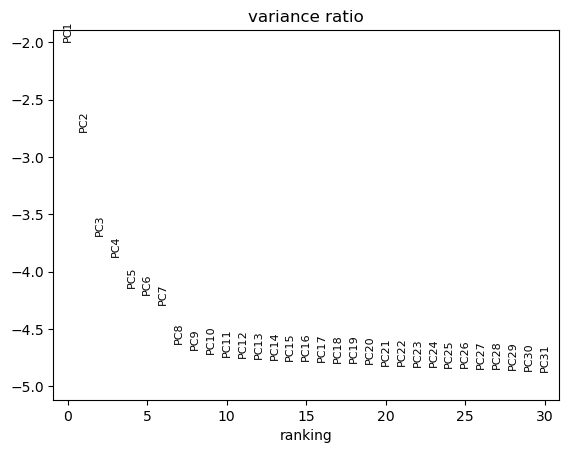

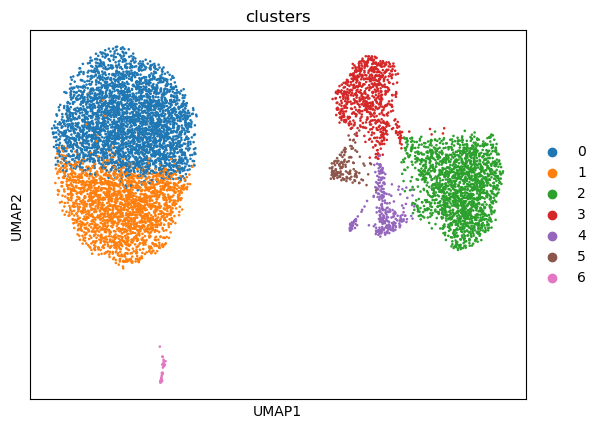

In [62]:
# Define the path of the analyzed data
dataPath = '../../../MERlin_Analysis/ProcessedResults/'
#dataPathRaw = '../../../MERlin_Analysis/'

# Define the experiment
experimentName = 'Msliver_Cellboundary_PM1_12172020'
prefixCounts = 'RawCounts/'
prefixSpatial = 'SpatialInfo/'
suffixCounts = '_FilteredSingleCellCounts.csv'
suffixSpatial = '_FilteredSingleCellSpatialInfo.csv'

# Load the MERlin results
# Note that this assumes the data has already been filtered through the MERlin_quality_control notebook

# Counts per segmented cell and spatial metadata
VizgenCounts = pd.read_csv(dataPath + prefixCounts + experimentName + suffixCounts)
VizgenSpatial = pd.read_csv(dataPath + prefixSpatial + experimentName + suffixSpatial)
#VizgenRaw = pd.read_csv(dataPathRaw + experimentName + '/ExportBarcodes/barcodes.csv')

# Read data into an AnnData object
ad_Vizgen = anndata.AnnData(VizgenCounts)

# Save the cell coordinate and volume information as well
coordinates = VizgenSpatial[['center_x','center_y']]
volumes = VizgenSpatial['volume']
ad_Vizgen.obsm['spatial'] = coordinates.to_numpy()
ad_Vizgen.obsm['volume'] = volumes.to_numpy()

N_counts_filter = 300 #Counts/cell filtering threshold

# Save a copy of the raw counts
ad_Vizgen_raw = []
# Preprocess the Anndata objects

scanpy.pp.filter_cells(ad_Vizgen, min_counts=N_counts_filter) #Filter based on total counts per cell
ad_Vizgen_raw.append(ad_Vizgen.copy()) #Save a copy of the raw counts
scanpy.pp.normalize_total(ad_Vizgen, target_sum=1e4) #Normalize the data to 10k counts
scanpy.pp.log1p(ad_Vizgen) #Logarithmize the data
scanpy.pp.scale(ad_Vizgen, max_value=10) #Scale each gene to unit variance and clip SD values over 10
scanpy.tl.pca(ad_Vizgen, svd_solver='arpack') #Compute PCA
    
# Plot the PCA variance ratios
scanpy.pl.pca_variance_ratio(ad_Vizgen, log=True)

# Calculate the individual UMAPs and do leiden clustering
scanpy.pp.neighbors(ad_Vizgen, n_neighbors=15, n_pcs=10) #Compute neighborhood graph (use n_neighbors = 12-15?)
scanpy.tl.umap(ad_Vizgen) #Compute UMAP embedding
scanpy.tl.leiden(ad_Vizgen, resolution=0.5, key_added='clusters')

# Plot the clustering results
scanpy.pl.umap(ad_Vizgen, color='clusters')

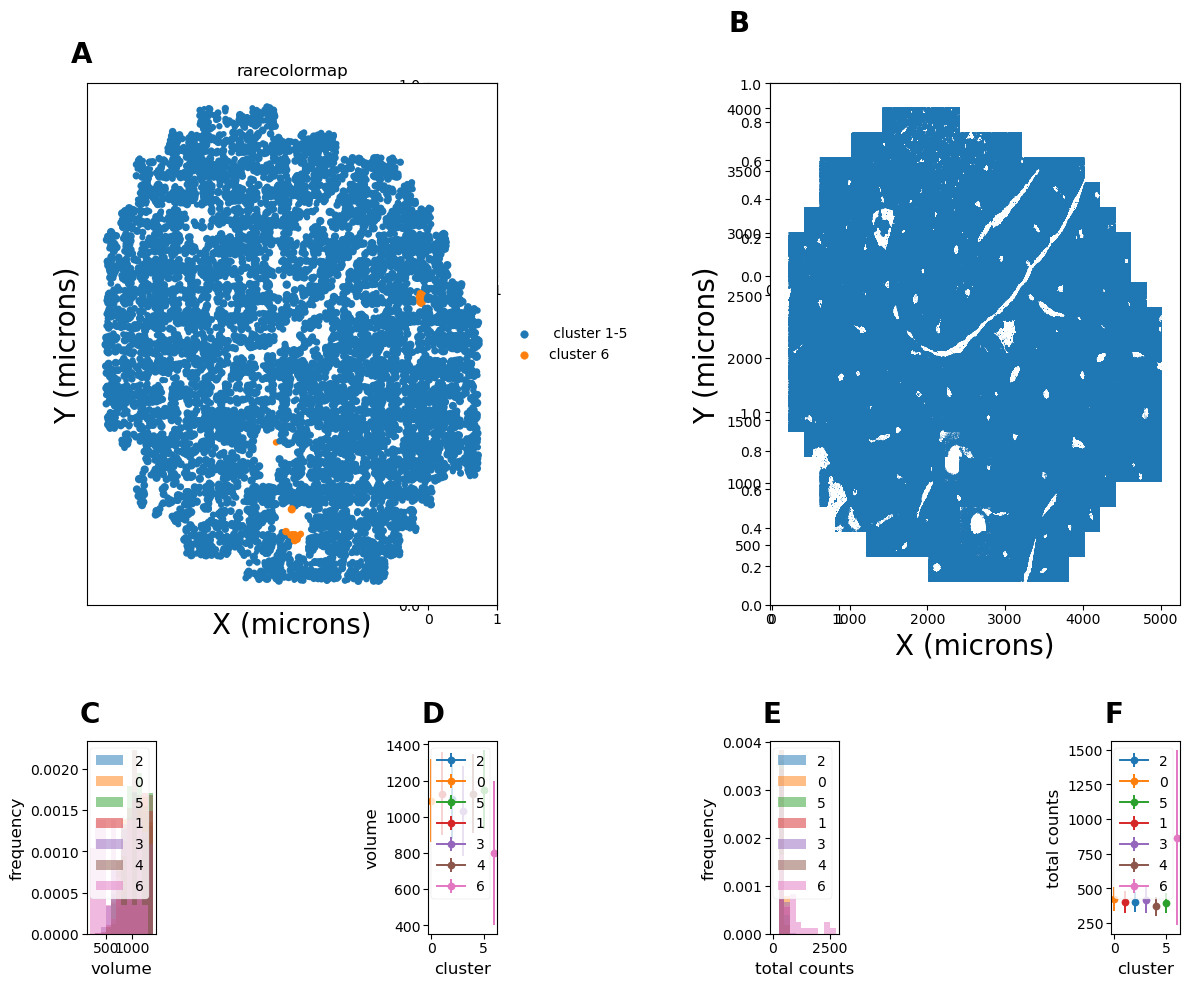

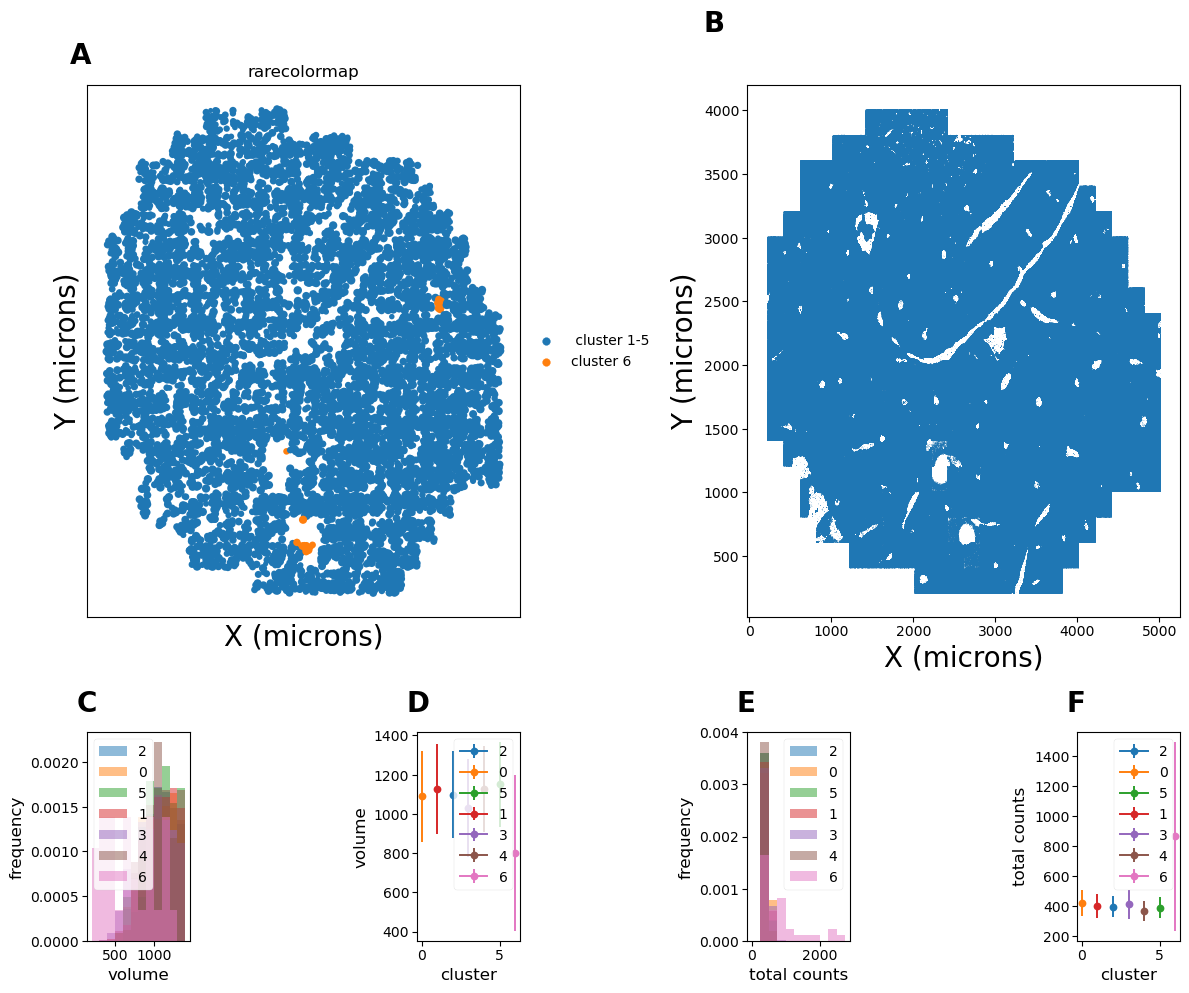

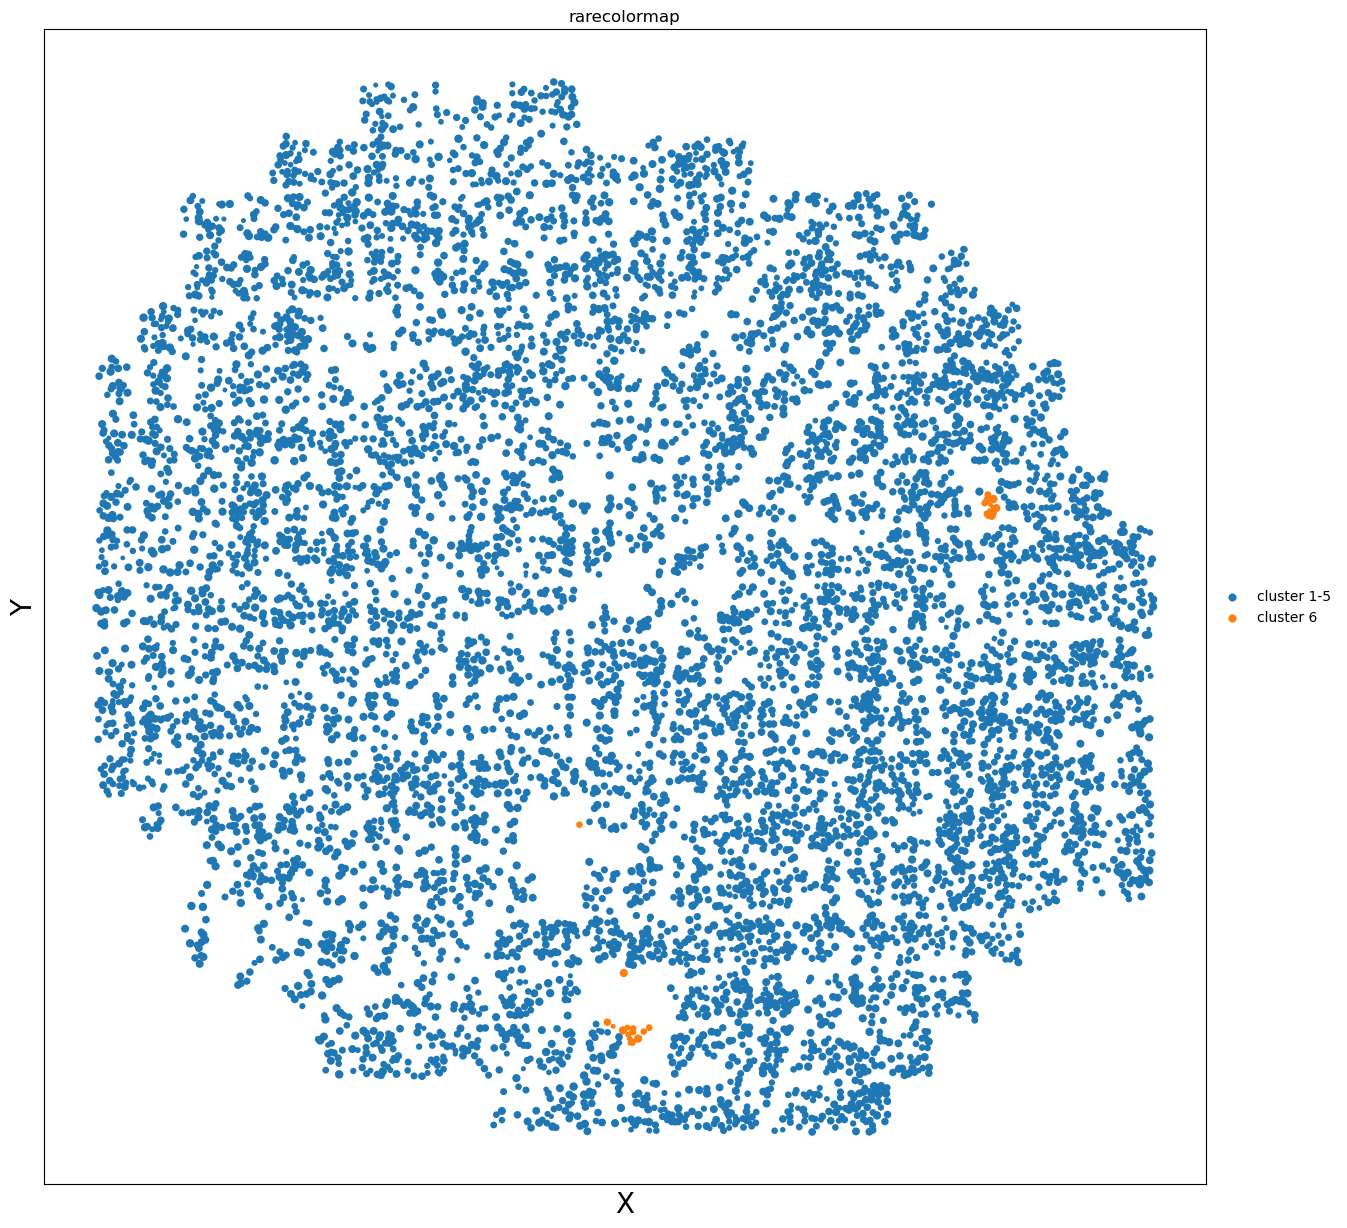

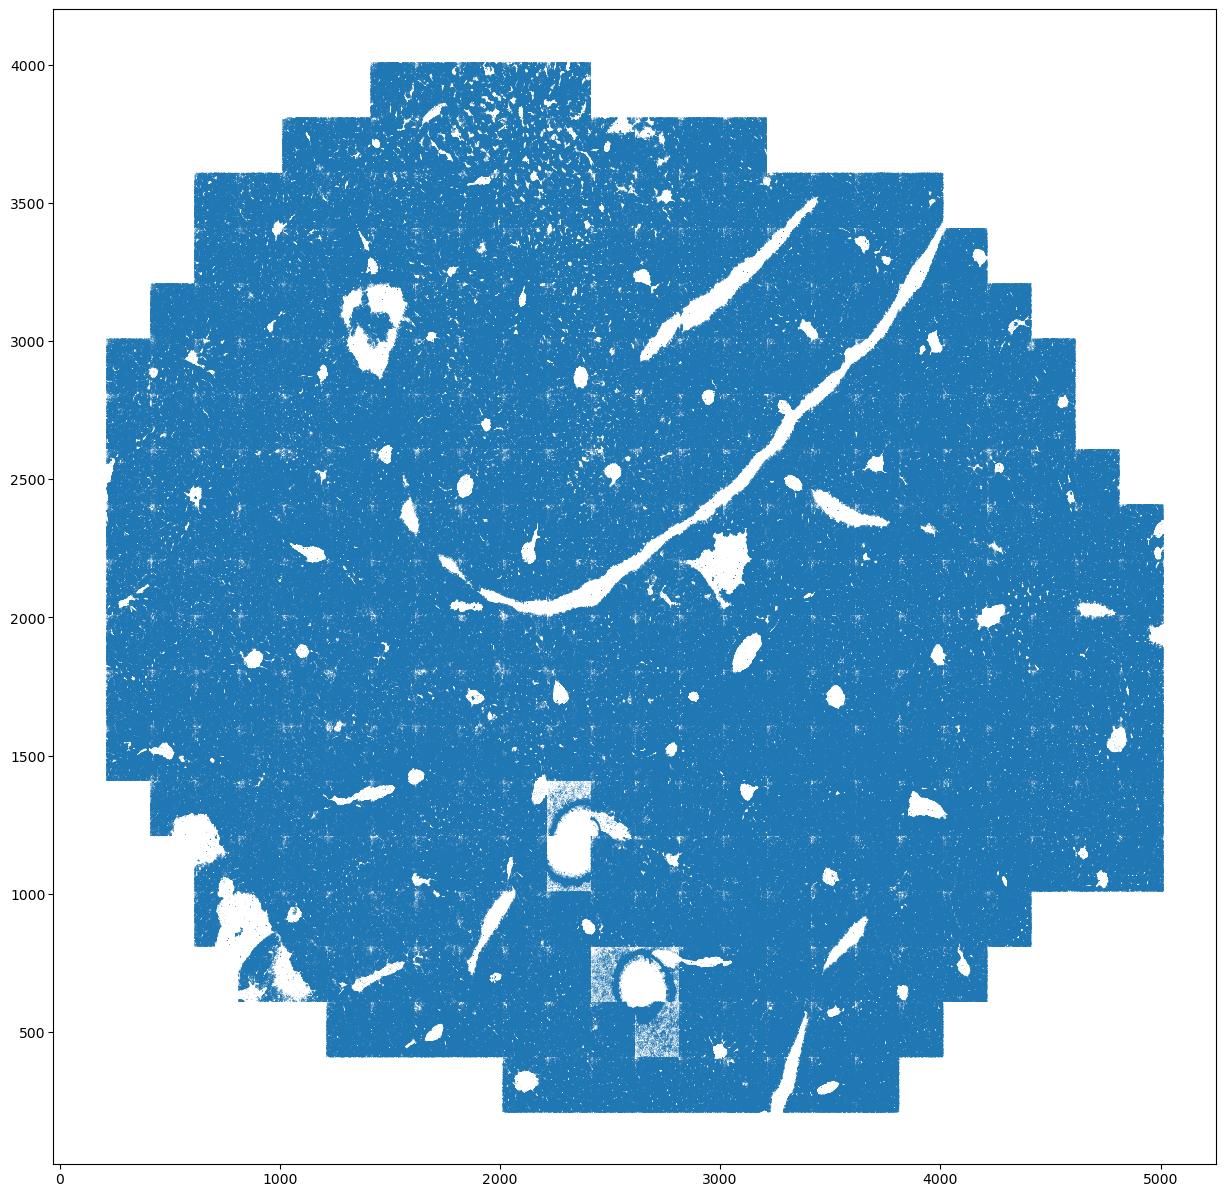

In [74]:
# Plot the cluster results in physical space as well as all detected transcripts

# Create a new observation based on clusters that to color only the rare cluster type
rareclusters = ad_Vizgen.obs.clusters == '6'
colormap = np.where(rareclusters, 'cluster 6','cluster 1-5')
ad_Vizgen.obs['rarecolormap'] = colormap
ad_Vizgen.obs['rarecolormap'] = ad_Vizgen.obs['rarecolormap'].astype('category')

#fig = plt.figure(figsize = (15,15))
fig, ax = plt.subplots(figsize = (15,15))
scanpy.pl.embedding(ad_Vizgen, basis="spatial", color="rarecolormap", size=ad_Vizgen.obsm['volume']/10, ax=ax, show=False)
#fig.gca().set_xlabel('X')
#fig.gca().set_ylabel('Y')
ax.set_xlabel('X', fontsize=20)
ax.set_ylabel('Y', fontsize=20)
plt.show()

# Plot all detected transcripts
#plt.figure(figsize=(15,15))
#plt.scatter(VizgenRaw['global_x'], VizgenRaw['global_y'], s=0.1, alpha=0.2)
#plt.show()


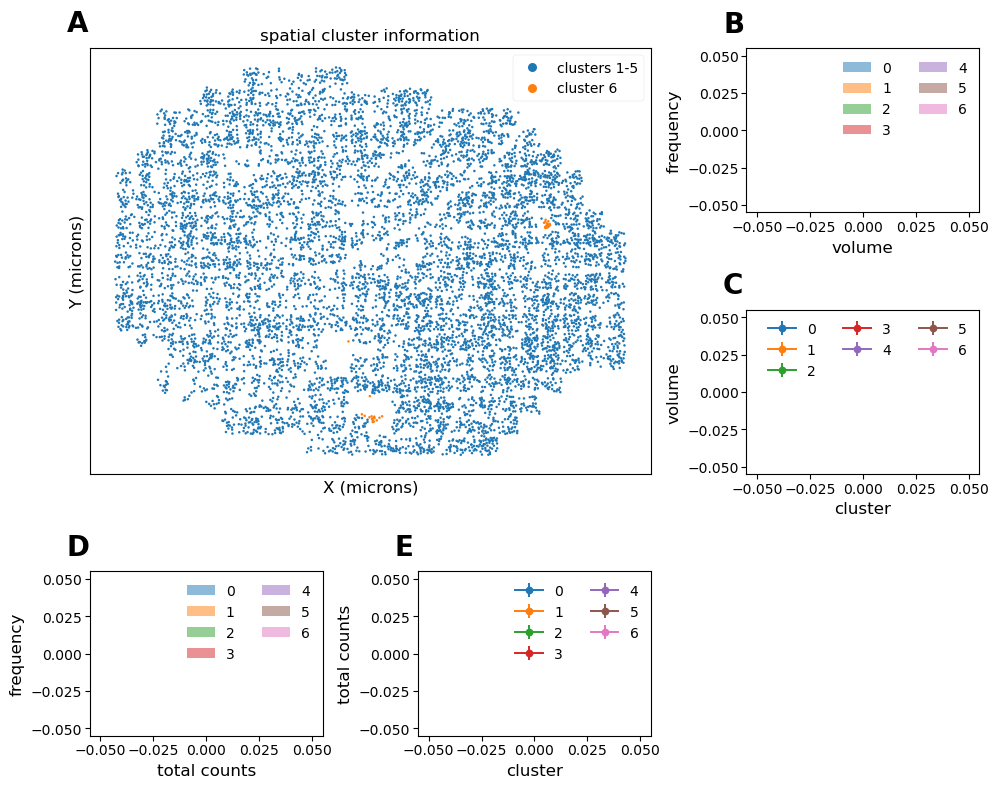

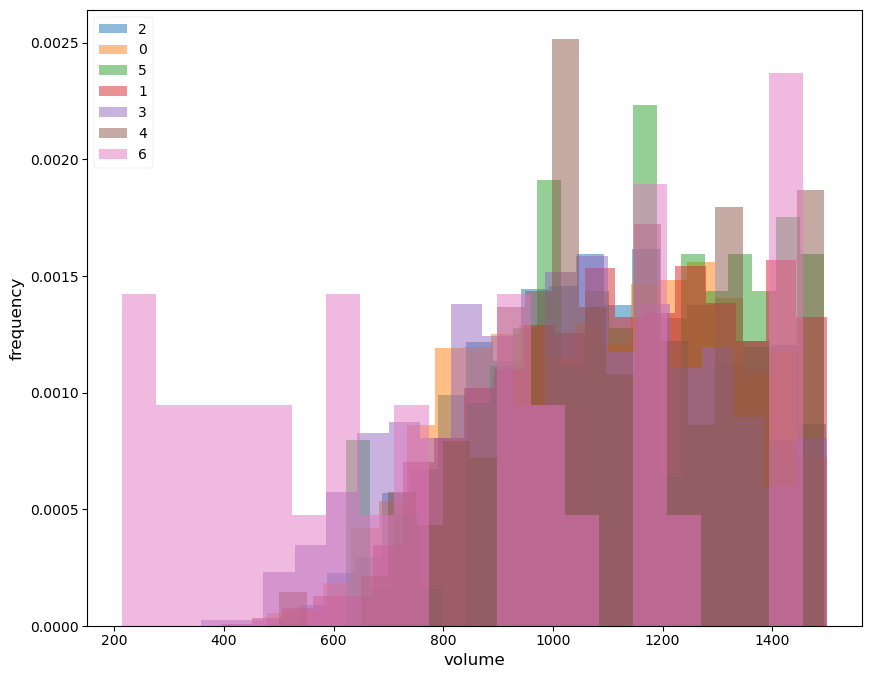

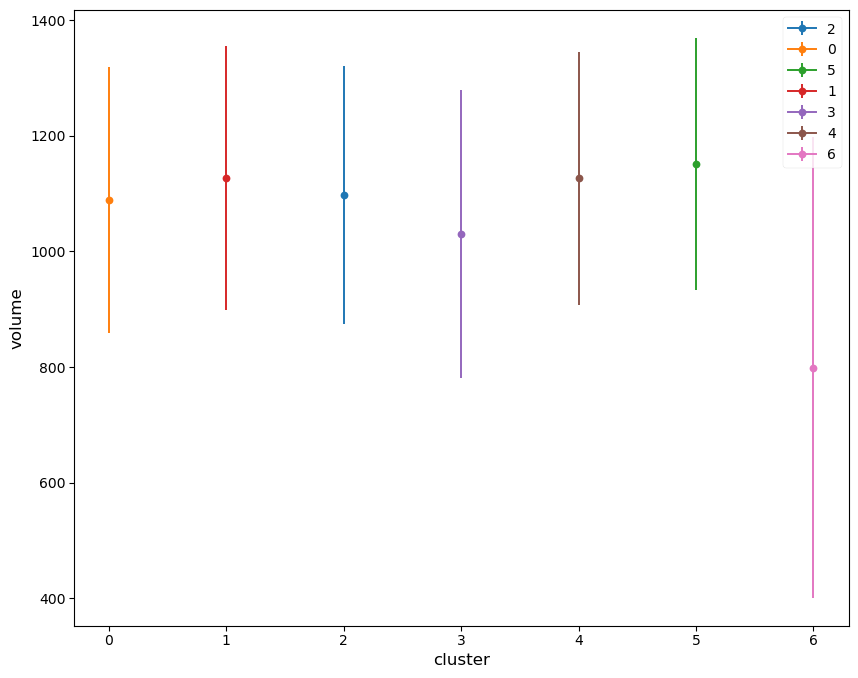

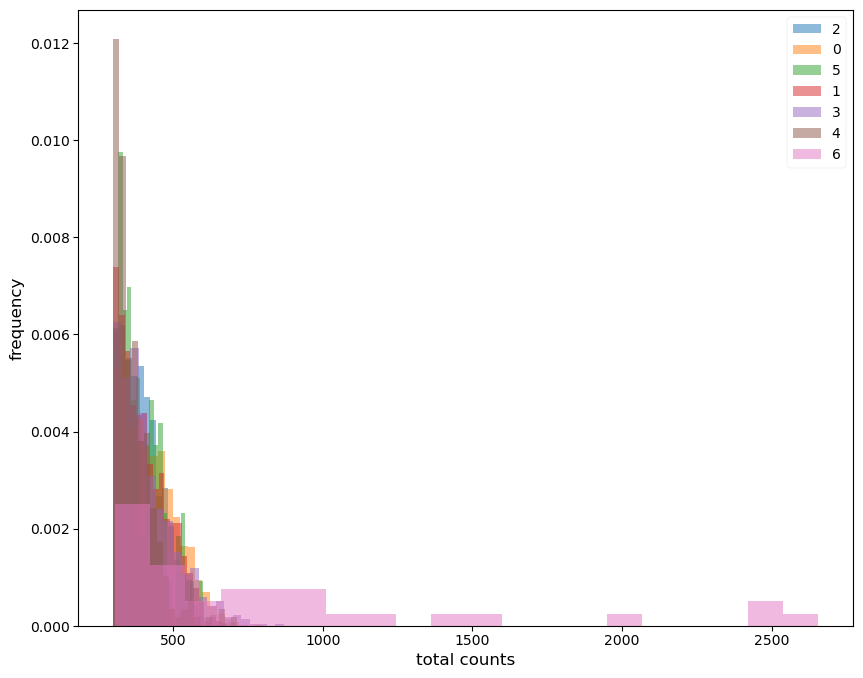

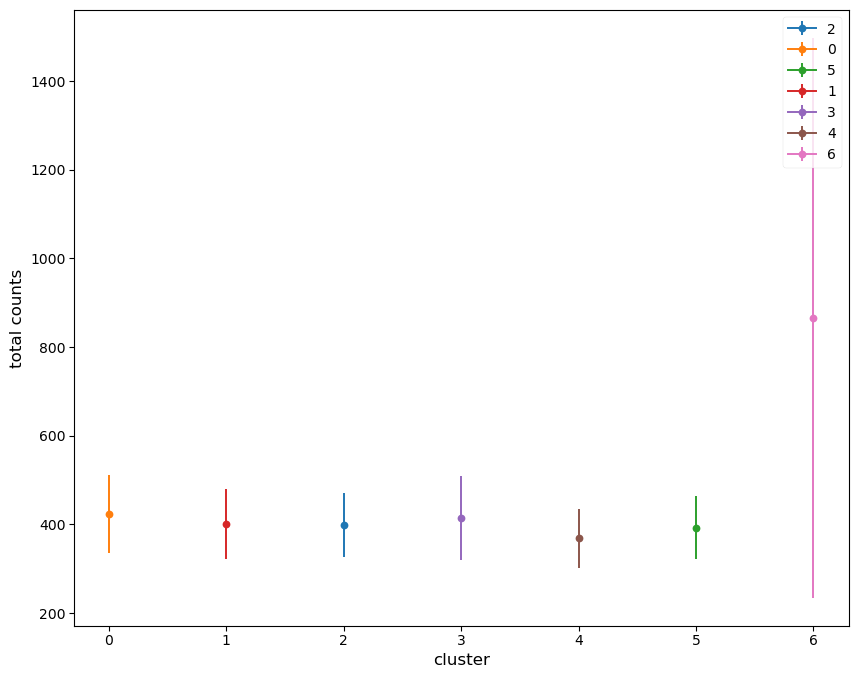

In [140]:
# Explore cell volume and counts distributions

# Cell indices for each cluster
clusterNames = ad_Vizgen.obs['clusters'].unique()
clusterInd = [ad_Vizgen.obs['clusters'] == clusterNames[i] for i in range(len(clusterNames))]

# Assign single cell volumes to each cluster
volumesPerCluster = [ad_Vizgen.obsm['volume'][clusterInd[i]] for i in range(len(clusterNames))]

# Assign single cell total counts to each cluster
countsPerCluster = [ad_Vizgen.obs['n_counts'][clusterInd[i]] for i in range(len(clusterNames))]

# Plot distributions for each cluster

# Volumes histogram
plt.figure()
[plt.hist(volumesPerCluster[i], bins = 20, alpha = 0.5, density=True, 
          label=clusterNames[i]) for i in range(len(clusterNames))]
plt.xlabel('volume')
plt.ylabel('frequency')
plt.legend()
plt.show()

# Volumes mean + SD
plt.figure()
[plt.errorbar(int(clusterNames[i]), np.mean(volumesPerCluster[i]), yerr = np.std(volumesPerCluster[i]),
              label=clusterNames[i], marker='o') for i in range(len(clusterNames))]
plt.xlabel('cluster')
plt.ylabel('volume')
plt.legend()
plt.show()

# Total counts histogram
plt.figure()
[plt.hist(countsPerCluster[i], bins = 20, alpha = 0.5, density=True, 
          label=clusterNames[i]) for i in range(len(clusterNames))]
plt.xlabel('total counts')
plt.ylabel('frequency')
plt.legend()
plt.show()

# Total counts mean + SD
plt.figure()
[plt.errorbar(int(clusterNames[i]), np.mean(countsPerCluster[i]), yerr = np.std(countsPerCluster[i]),
              label=clusterNames[i], marker='o') for i in range(len(clusterNames))]
plt.xlabel('cluster')
plt.ylabel('total counts')
plt.legend()
plt.show()

### Plot final figure

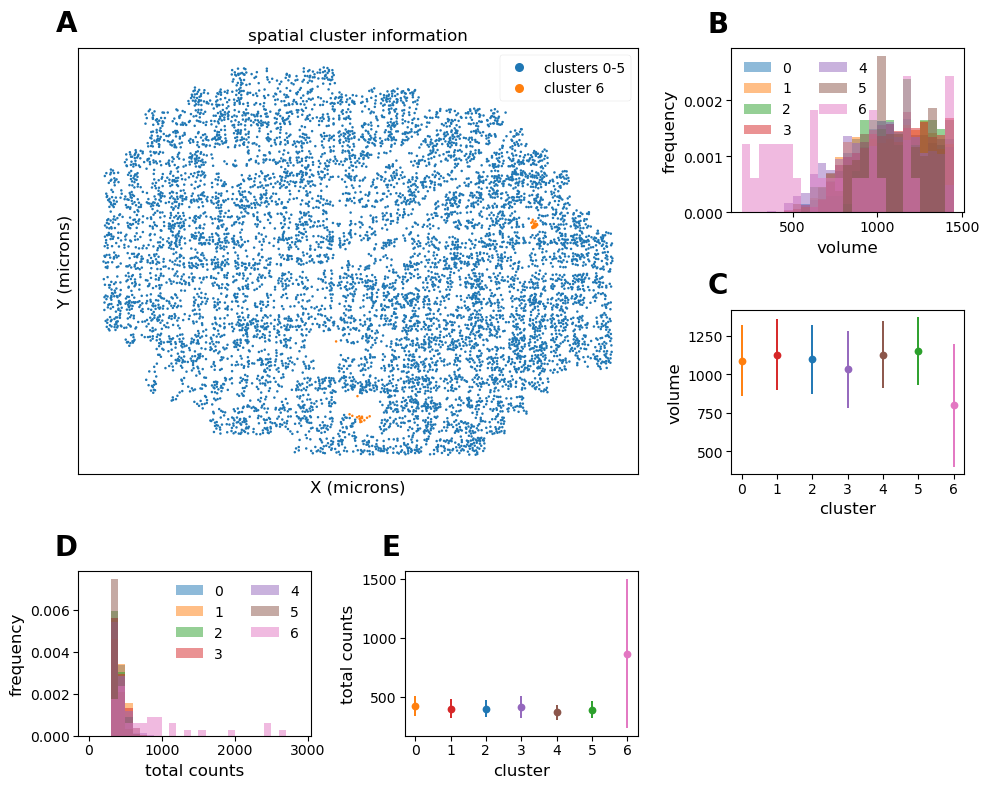

In [149]:
set_plotting_style()

# Plot the whole figure
fig, ax = plt.subplots(ncols=3, nrows=3) #Create 3x3 griud
gs = ax[0,0].get_gridspec() #Get gridspecs

# remove the underlying axes for Panel A and B, as well as the bottom right corner
for i in [0,1]:
    for j in [0,1]:
        ax[i,j].remove()
ax[2,2].remove()

axbig1 = fig.add_subplot(gs[0:2, 0:2])

# Panel A
axbig1 = scanpy.pl.embedding(ad_Vizgen, basis="spatial", legend_loc='upper right', title='spatial cluster information',
                             color="rarecolormap", size=13, ax=axbig1, show=False)
axbig1.set_xlabel('X (microns)')
axbig1.set_ylabel('Y (microns)')

# Add custom legend since I can't get scanpy legend to work right
legend_elements = [Line2D([0], [0], marker='.', color=colors[0], label='clusters 0-5',
                          markerfacecolor=colors[0], markersize=13, linestyle='none'),
                   Line2D([0], [0], marker='.', color=colors[1], label='cluster 6',
                          markerfacecolor=colors[1], markersize=13, linestyle='none')]


axbig1.legend(handles=legend_elements, loc='upper right')

clusterNamesSorted = np.sort(clusterNames.astype(int))
# Panel B
bins = np.arange(200,1500,50)
[ax[0,2].hist(volumesPerCluster[i], bins = bins, alpha = 0.5, density=True, 
          label=clusterNamesSorted[i]) for i in range(len(clusterNames))]
ax[0,2].set_xlabel('volume')
ax[0,2].set_ylabel('frequency')
ax[0,2].legend(ncol=2, framealpha=0)

# Panel C
[ax[1,2].errorbar(int(clusterNames[i]), np.mean(volumesPerCluster[i]), yerr = np.std(volumesPerCluster[i]),
              label=clusterNamesSorted[i], marker='o') for i in range(len(clusterNames))]
ax[1,2].set_xlabel('cluster')
ax[1,2].set_ylabel('volume')
ax[1,2].set_xticks(np.arange(0,7))
#ax[1,2].legend(ncol=3, framealpha=0)

# Panel D
bins = np.arange(0,3000,100)
[ax[2,0].hist(countsPerCluster[i], bins = bins, alpha = 0.5, density=True, 
          label=clusterNamesSorted[i]) for i in range(len(clusterNames))]
ax[2,0].set_xlabel('total counts')
ax[2,0].set_ylabel('frequency')
ax[2,0].legend(ncol=2, framealpha=0)

# Panel E
[ax[2,1].errorbar(int(clusterNames[i]), np.mean(countsPerCluster[i]), yerr = np.std(countsPerCluster[i]),
              label=clusterNamesSorted[i], marker='o') for i in range(len(clusterNames))]
ax[2,1].set_xlabel('cluster')
ax[2,1].set_ylabel('total counts')
#ax[2,1].legend(ncol=2, framealpha=0)
ax[2,1].set_xticks(np.arange(0,7))

# Label subpanels
axes = [axbig1, ax[0,2], ax[1,2], ax[2,0], ax[2,1]]
for n, ax in enumerate(axes):
    if n == 0:
        ax.text(-0.04, 1.04, string.ascii_uppercase[n], transform=ax.transAxes, 
                size=20, weight='bold')
    else:
        ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
                size=20, weight='bold')
fig.tight_layout()

fig


In [137]:
np.sort(clusterNames.astype(int))

array([0, 1, 2, 3, 4, 5, 6])

In [150]:
# Export figures
fig.savefig('../../figures/SIFig_rare_cluster_refutation.pdf')
fig.savefig('../../figures/SIFig_rare_cluster_refutation.png')